In [1]:
import os
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, TimeDistributed, Bidirectional, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


from IPython.display import HTML
from base64 import b64encode

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')



In [2]:
#For play video
def Play_Video(filepath):
    html = ''
    video = open(filepath,'rb').read()
    src = 'data:video/mp4;base64,' + b64encode(video).decode()
    html += '<video width=640 muted controls autoplay loop><source src="%s" type="video/mp4"></video>' % src 
    return HTML(html)

In [3]:
# Paths
VIOLENCE_PATH = "data/Violence"
NONVIOLENCE_PATH = "data/NonViolence"

In [4]:
# Configs
SEQUENCE_LENGTH = 16
IMG_HEIGHT = 64
IMG_WIDTH = 64

CHANNELS = 3

BATCH_SIZE = 32
EPOCHS = 50

### Load 

In [5]:
def extract_frames(video_path, sequence_length, img_height, img_width, channels):
    """
    Extracts uniformly spaced, resized, and normalized RGB frames from a video.
    """
    frames = []
    cap = cv2.VideoCapture(video_path)

    # Return empty if video cannot be opened or has no frames
    if not cap.isOpened() or int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) == 0:
        print(f"Error: Could not process video file {video_path}")
        return np.array([])

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    indices = np.linspace(0, total_frames - 1, sequence_length, dtype=int)

    for idx in indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()

        if ret:
            # Resize, convert to RGB, and normalize frame
            resized_frame = cv2.resize(frame, (img_width, img_height))
            rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
            normalized_frame = rgb_frame.astype(np.float32) / 255.0
            frames.append(normalized_frame)
        else:
            # Append last successful frame or a black frame if read fails
            frames.append(frames[-1] if frames else np.zeros((img_height, img_width, channels), dtype=np.float32))

    cap.release()
    return np.array(frames)


def load_dataset(violence_path, nonviolence_path, sequence_length, img_height, img_width, channels):
    """
    Loads video sequences and their corresponding labels for a binary classification task.
    """
    sequences = []
    labels = []

    for label, path in [(1, violence_path), (0, nonviolence_path)]: # 1 for violence, 0 for non-violence
        if os.path.exists(path):
            video_files = [f for f in os.listdir(path) if f.lower().endswith(('.mp4', '.avi', '.mov'))]
            
            for video_filename in tqdm(video_files, desc=f"Loading {'Violence' if label else 'Non-Violence'} videos"):
                video_full_path = os.path.join(path, video_filename)
                extracted_frames = extract_frames(video_full_path, sequence_length, img_height, img_width, channels)
                
                # Append if frames are valid and meet the required sequence length
                if extracted_frames.size > 0 and len(extracted_frames) == sequence_length:
                    sequences.append(extracted_frames)
                    labels.append(label)
                else:
                    print(f"Skipping video: {video_filename} due to insufficient or no frames.")
        else:
            print(f"Warning: Path does not exist: {path}. Skipping this category.")

    if not sequences:
        raise ValueError("No videos found. Please check dataset paths and file formats.")

    return np.array(sequences), np.array(labels)

In [6]:
# Load the dataset
X, y = load_dataset(VIOLENCE_PATH, NONVIOLENCE_PATH, SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, CHANNELS)

# Split the data: 80% for training + validation and 20% for testing
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# From the 80% training set, take 20% for validation (which is 16% of the full dataset)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)

Loading Non-Violence videos: 100%|██████████| 1000/1000 [04:53<00:00,  3.41it/s]


In [13]:
class ViolenceDetectionModel:
    def __init__(self, sequence_length=16, img_height=64, img_width=64, channels=3, fine_tune_mobilenet=False):
        self.sequence_length = sequence_length
        self.img_height = img_height
        self.img_width = img_width
        self.channels = channels
        self.fine_tune_mobilenet = fine_tune_mobilenet # Novo parâmetro para fine-tuning
        self.model = None
        self.history = None

    def create_cnn_mobilenet(self):
        """
        Creates a CNN model using MobileNetV2 as a feature extractor.
        """
        # Load MobileNetV2 pre-trained on ImageNet, without the top classification layer
        mobilenet = MobileNetV2(
            input_shape=(self.img_height, self.img_width, self.channels),
            include_top=False, # Important: Exclude the classifier part
            weights='imagenet' # Use pre-trained weights
        )

        # Freeze the layers of MobileNetV2 so their weights are not updated during training
        if not self.fine_tune_mobilenet:
            for layer in mobilenet.layers:
                layer.trainable = False

        # Build a Sequential model on top of MobileNetV2 for feature extraction
        model = Sequential([
            mobilenet, # The pre-trained MobileNetV2 base
            tf.keras.layers.GlobalAveragePooling2D() # Reduces spatial dimensions to a single feature vector
        ])
        return model

    def build(self):
        """
        Builds the complete Bidirectional LSTM model with MobileNetV2 as CNN.
        """
        input_layer = Input(shape=(self.sequence_length, self.img_height, self.img_width, self.channels))
        cnn_extractor = self.create_cnn_mobilenet() # Use the MobileNetV2 based CNN

        # Apply the CNN feature extractor to each frame in the sequence
        features = TimeDistributed(cnn_extractor)(input_layer)

        # Bidirectional LSTM layers to learn temporal patterns
        x = Bidirectional(LSTM(64, return_sequences=True, dropout=0.3))(features)
        x = Bidirectional(LSTM(32, dropout=0.3))(x)

        # Dense layers for final classification
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.3)(x)
        x = Dense(32, activation='relu')(x)
        x = Dropout(0.3)(x)

        # Output layer for binary classification
        output = Dense(1, activation='sigmoid')(x)

        self.model = Model(inputs=input_layer, outputs=output)
        self.model.compile(
            optimizer=Adam(learning_rate=0.0001), # Adam optimizer
            loss='binary_crossentropy', # Binary cross-entropy for binary classification
            metrics=['accuracy', 'precision', 'recall'] # Evaluation metrics
        )
        return self.model

In [14]:
def train_model(model, X_train, y_train, X_val, y_val, epochs, batch_size):
    callbacks = [
        ModelCheckpoint('models/best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max'),
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True), # Automatic stop after 10 epochs in case of no improvements
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
    ]
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    return history

def evaluate_model(model, X_test, y_test):
    y_prob = model.predict(X_test)
    y_pred = (y_prob > 0.5).astype(int).flatten()
    print(classification_report(y_test, y_pred, target_names=["Non-Violence", "Violence"]))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Non-Violence", "Violence"], yticklabels=["Non-Violence", "Violence"])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    return y_pred, y_prob


def plot_training(history):
    metrics = ['accuracy', 'loss', 'precision', 'recall']
    plt.figure(figsize=(15, 10))
    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        plt.plot(history.history[metric], label='Train')
        plt.plot(history.history[f'val_{metric}'], label='Val')
        plt.title(metric.capitalize())
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
    plt.tight_layout()
    plt.show()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 16, 64, 64, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 16, 1280)       │     2,257,984 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 16, 128)        │       688,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,994,113 (11.42 MB)

 Trainable params: 736,129 (2.81 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.5074 - loss: 0.7022 - precision: 0.5233 - recall: 0.3493 - val_accuracy: 0.6125 - val_loss: 0.6816 - val_precision: 0.5938 - val_recall: 0.7125 - learning_rate: 1.0000e-04
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5508 - loss: 0.6834 - precision: 0.5743 - recall: 0.5356 - val_accuracy: 0.6625 - val_loss: 0.6642 - val_precision: 0.6171 - val_recall: 0.8562 - learning_rate: 1.0000e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6181 - loss: 0.6660 - precision: 0.6222 - recall: 0.6260 - val_accuracy: 0.7219 - val_loss: 0.6361 - val_precision: 0.6699 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.6573 - loss: 0.6515 - precision: 0.6417 - recall: 0.6319 - val_accuracy: 0.7500 - val_loss: 0.5919 - val_precision: 0.7041 - val_recall: 0.8625 - learning_rate: 1.0000e-04
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - acc

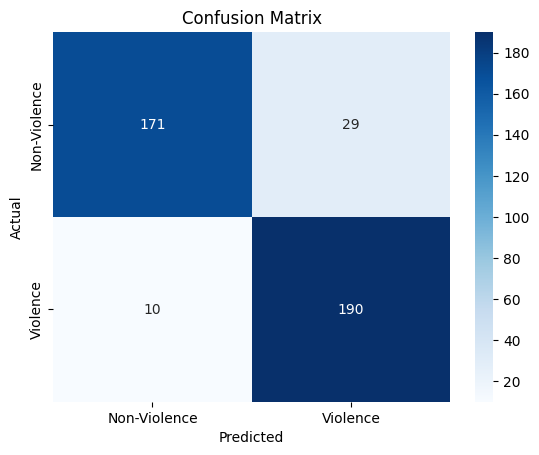

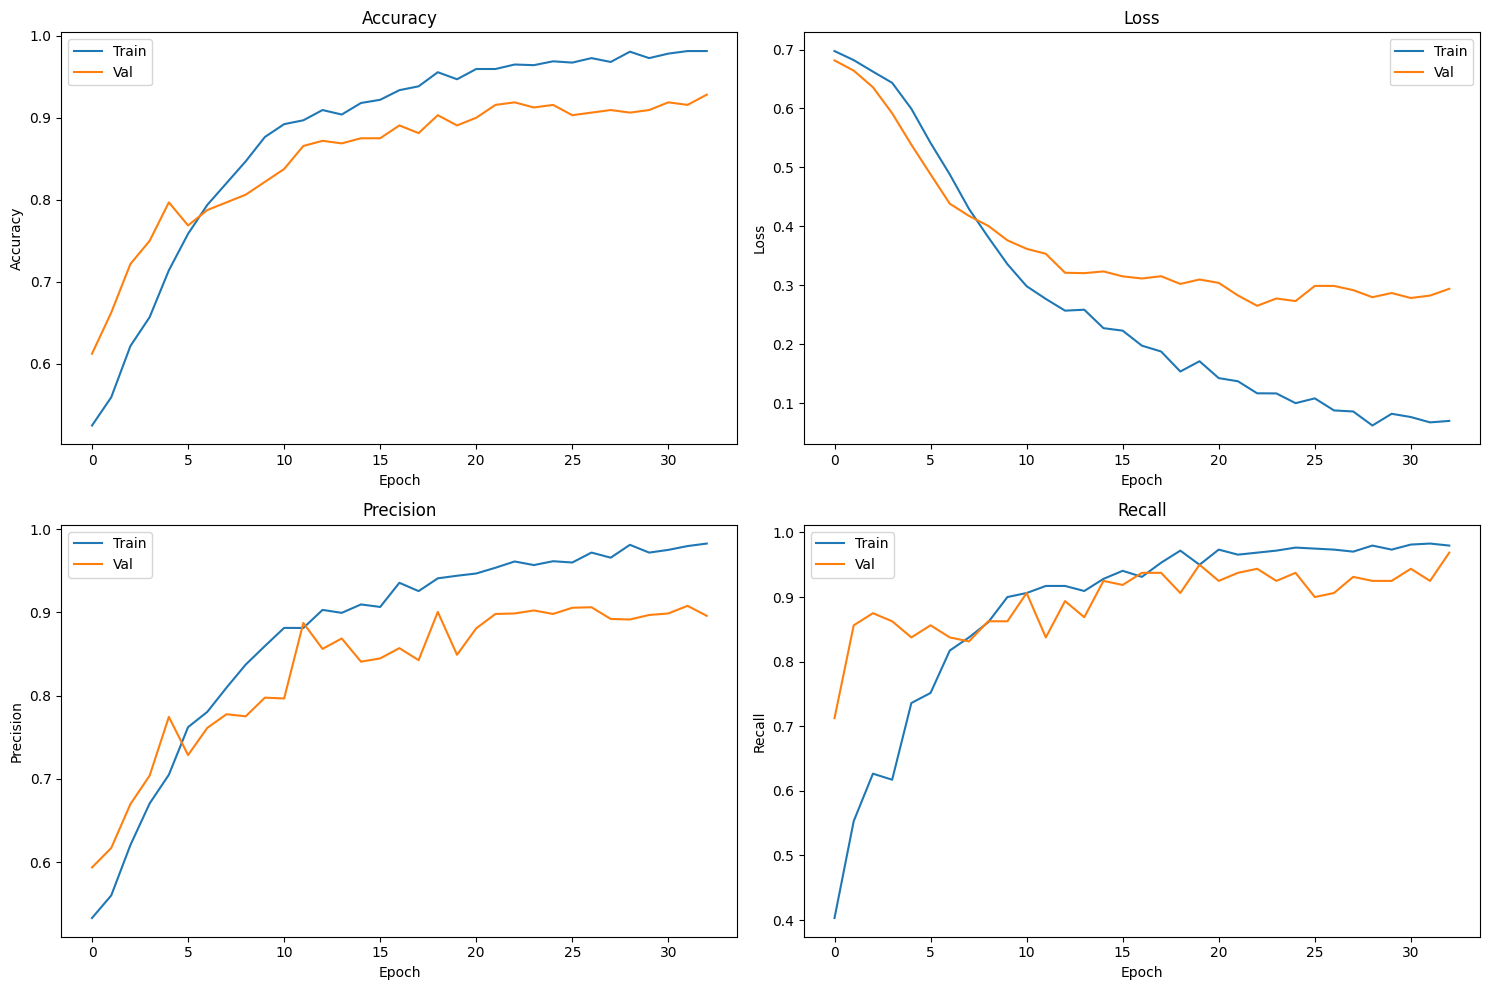

In [ ]:
# Build and train the model
model_builder = ViolenceDetectionModel(SEQUENCE_LENGTH, IMG_HEIGHT, IMG_WIDTH, CHANNELS, fine_tune_mobilenet=False)
model = model_builder.build()
model.summary() # Displays the model summary

history = train_model(model, X_train, y_train, X_val, y_val, EPOCHS, BATCH_SIZE)


# Evaluate the model and plot metrics
evaluate_model(model, X_test, y_test)
plot_training(history)


# Save the final model
model.save("models/last_model.keras")
